<a href="https://colab.research.google.com/github/sofia-sunny/QSAR/blob/main/QSAR_for_EGFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **QSAR for EGFR**
The Epidermal Growth Factor Receptor (**EGFR**) is a transmembrane protein and member of the receptor tyrosine kinase family that plays a crucial role in regulating cell growth, survival, proliferation, and differentiation.Dysregulation of EGFR is implicated in the development and progression of various cancers, including non-small cell lung cancer, colorectal cancer, and glioblastoma. EGFR has become an important therapeutic target, with several small-molecule inhibitors and monoclonal antibodies developed to block its signaling activity in cancer cells.

In this tutorial, we will use **QSAR  modeling to predict the biological activity (pIC50) of small molecules targeting EGFR**, based on their molecular structure.

In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 34.1 MB/s eta 0:00:00


In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import  GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

First getting data:

In [ ]:
file_name = 'https://raw.githubusercontent.com/sofia-sunny/Deep-Dive-Tutorials/main/data/chembl_data_1.csv'

In [ ]:
data = pd.read_csv(file_name)
data

,ChEMBL_ID,SMILES,pIC50
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,6.522879
2,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,5.106793
3,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,6.769551
4,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,7.397940
...,...,...,...
956,CHEMBL168921,CC(C)(C)OC(=O)N1CCC(n2cc(-c3cccc(O)c3)c3c(N)nc...,5.657577
957,CHEMBL168921,CC(C)(C)OC(=O)N1CCC(n2cc(-c3cccc(O)c3)c3c(N)nc...,5.000000
958,CHEMBL169065,COC(=O)CN1CCC(n2cc(-c3cccc(OC)c3)c3c(N)ncnc32)CC1,5.832683
959,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,4.017729


The same compound, identified by its **ChEMBL ID**, may have multiple reported activities due to differences in assays, measurement techniques, or experimental conditions.

By grouping the data based on ChEMBL_ID and computing the mean of the pIC50 values, we obtain a single representative activity value for each unique compound.

In [ ]:
df = data.groupby('ChEMBL_ID', as_index=False).agg({
    'SMILES': 'first', # keep the first SMILES
    'pIC50': 'mean'
})
df

,ChEMBL_ID,SMILES,pIC50
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,4.017729
1,CHEMBL100714,COc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1OC,5.552842
2,CHEMBL1009,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,3.045757
3,CHEMBL101581,COc1cc2nccc(Oc3cccc(Br)c3)c2cc1OC,5.602060
4,CHEMBL104153,COc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3n...,6.657577
...,...,...,...
775,CHEMBL97162,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2[C@H]2CC[C@H](O...,7.080922
776,CHEMBL98137,COc1ccc(Nc2ccnc3cc(OC)c(OC)cc23)cc1OC,4.094204
777,CHEMBL98248,COc1cc2nccc(Nc3cccc(Br)c3)c2cc1OC,6.431798
778,CHEMBL98798,COc1cc2ncnc(Oc3cccc(Br)c3)c2cc1OC,7.154902


### **Generating  descriptors**
Remember that machine learning models require numerical features as input. SMILES strings, while useful as a chemical representation, are not directly interpretable by algorithms—they are just text. The descriptors capture the underlying chemical and structural characteristics that influence a molecule's biological activity.

In [ ]:
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            'MolWt': Descriptors.MolWt(mol),
            'MolLogP': Descriptors.MolLogP(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
            'RingCount': Descriptors.RingCount(mol),
            'FractionCSP3': Descriptors.FractionCSP3(mol),
            'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
            'NHOHCount': Descriptors.NHOHCount(mol),
        }
    return None

desc_list = df['SMILES'].apply(compute_descriptors)
desc_df = pd.DataFrame([x for x in desc_list if x is not None])
df_clean = df[desc_list.notnull()].reset_index(drop=True)
df_final = pd.concat([df_clean, desc_df], axis=1)
df_final.head()

,ChEMBL_ID,SMILES,pIC50,MolWt,MolLogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,RingCount,FractionCSP3,HeavyAtomCount,NHOHCount
0,CHEMBL10,C[S+]([O-])c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc...,4.017729,377.444,4.6822,1,3,64.63,4,4,0.047619,27,1
1,CHEMBL100714,COc1ccc(Nc2ncnc3cc(OC)c(OC)cc23)cc1OC,5.552842,341.367,3.4078,1,7,74.73,6,3,0.222222,25,1
2,CHEMBL1009,N[C@@H](Cc1ccc(O)c(O)c1)C(=O)O,3.045757,197.190,0.0522,4,4,103.78,3,1,0.222222,14,5
3,CHEMBL101581,COc1cc2nccc(Oc3cccc(Br)c3)c2cc1OC,5.602060,360.207,4.8068,0,4,40.58,4,3,0.117647,22,0
4,CHEMBL104153,COc1ccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3n...,6.657577,427.291,5.0545,1,6,69.04,4,4,0.095238,29,1


### **Feature Selection**
Feature selection involves identifying the **most relevant molecular descriptors** that have the greatest impact on a target outcome, such as biological activity or toxicity. By selecting only the most informative features, researchers can reduce model complexity, improve prediction accuracy, and minimize overfitting.

To identify the subset of features that contribute most to predictive power, a **hybrid strategy** is often the most effective. This involves starting with **filter-based methods** to remove descriptors that have low variance or are highly correlated with others ( thereby reducing redundancy.) Then, more **refined model-based techniques**, such as recursive feature elimination with cross-validation **(RFECV)** or feature importance ranking from tree-based models (e.g., Random Forest).

First X and y are defined:

In [ ]:
X = df_final.drop(columns=['ChEMBL_ID', 'SMILES', 'pIC50'])  # Keep only descriptors
y = df_final['pIC50']

### **Feature Scaling**
Feature scaling ensures all molecular descriptors contribute equally to the model by transforming them to a similar range or distribution. Without scaling, features with larger numeric ranges (like molecular weight) can dominate others (like LogP), leading to biased or unstable models

In [ ]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

**Filter method to remove low-variance features**

Features with low variance carry little information.
For example, if a feature has nearly the same value for every molecule, it won’t help a model distinguish between different outputs (e.g., activity, toxicity).

Here the `VarianceThreshold` method is initialized with a threshold of 0.01, meaning any feature in X with variance less than 0.01 will be excluded.

In [ ]:
print(f"before: {X.shape}")
var_thresh = VarianceThreshold(threshold=0.05)
X_var = var_thresh.fit_transform(X)
X_var_df = X.iloc[:, var_thresh.get_support(indices=True)]
print(f"after: {X_var_df.shape}")

before: (780, 10)
after: (780, 9)


**Filter method to remove highly correlated features**

Highly correlated features are removed to reduce multicollinearity, a condition where two or more features in a dataset are strongly  related.

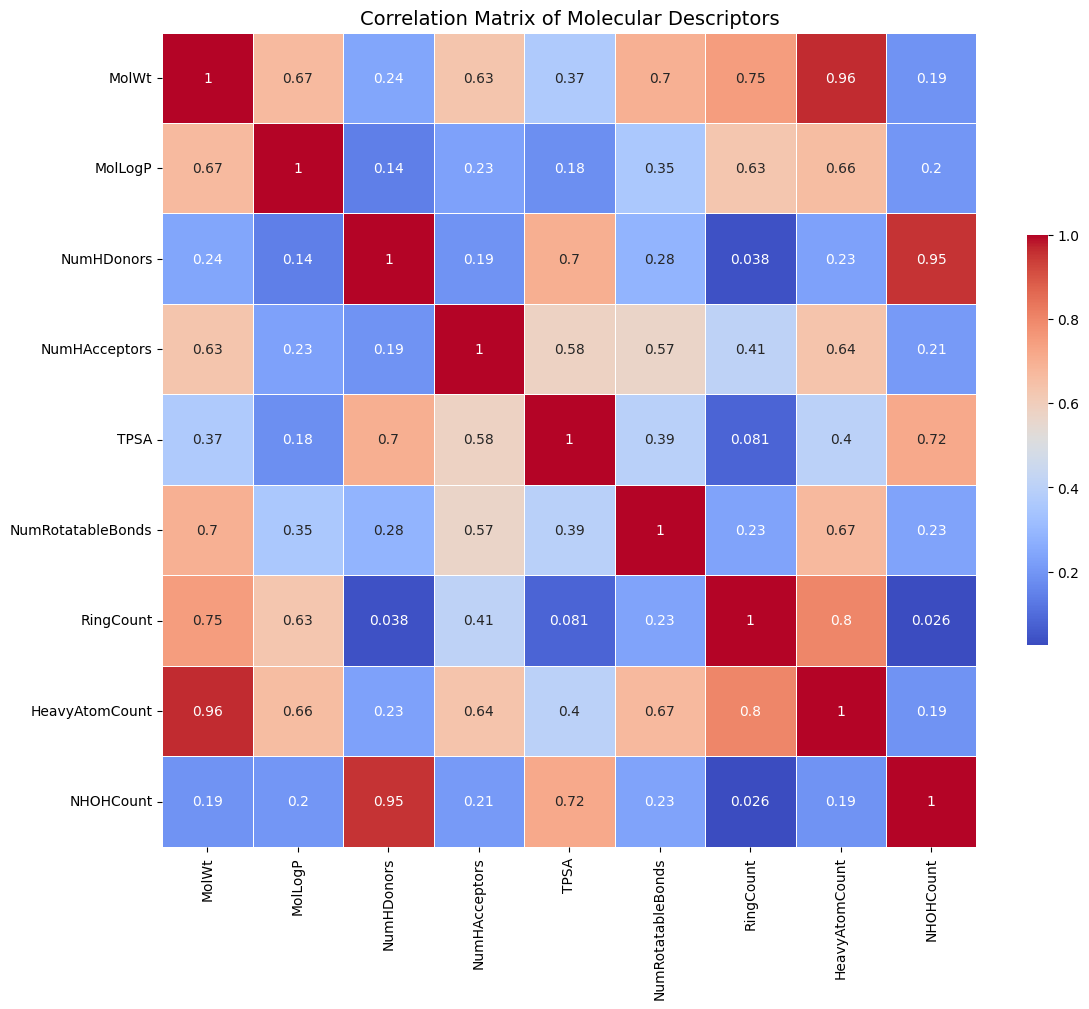

In [ ]:
corr_matrix = X_var_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, square=True,
            cbar_kws={"shrink": 0.5}, linewidths=0.5)
plt.title("Correlation Matrix of Molecular Descriptors", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In the correlation matrix, **MolWt–HeavyAtomCount** (0.96) and **NumHDonors–NHOHCount** (0.95) show strong multicollinearity. Such high correlation can introduce redundancy and reduce model reliability. Removing one feature from each pair helps improve model performance and interpretability.


In [ ]:
print(f"before drop: {X_var_df.shape}")
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X_filtered = X_var_df.drop(columns=to_drop)
print(f"after drop: {X_filtered.shape}")

before drop: (780, 9)
after drop: (780, 7)


## **Splitting Data**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)


### **Optimizing Feature Selection with RFECV and Random Forest**
Recursive Feature Elimination with Cross-Validation (**RFECV**) is an advanced feature selection technique that systematically identifies the most relevant input variables for a predictive model. When combined with a **Random Forest regressor**, RFECV leverages the model’s inherent ability to rank features by importance while using **cross-validation** to evaluate performance at each step. The process recursively removes the least important features, retraining the model multiple times, and selects the **optimal subset of features based on the cross-validated performance metric**.

The **RFECV object** is configured to eliminate one feature at a time (step=1) and evaluate model performance using the **negative mean squared error** as the scoring metric. The model is then trained on the training data, and the most relevant features are selected based on cross-validated performance.

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(rf, step=1, cv=cv, scoring="neg_mean_squared_error")
selector.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=RandomForestRegressor(random_state=42),
      scoring='neg_mean_squared_error')

### **Select optimal features**
The **feature selector** trained by RFECV is now applied to transform the original training and test datasets. The **`transform()`** method retains only the most relevant features identified during cross-validation, effectively reducing the dimensionality of the input data.

In [ ]:
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

### **Final model training and evaluation**
In this final step, a **Random Forest model** is trained using the optimal features selected through **RFECV**. The model is fitted to the **reduced training set (X_train_sel)**, and predictions are made on the **reduced test set (X_test_sel)**. The model's performance is then evaluated by calculating the Mean Squared Error (**MSE**),

In [ ]:
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train_sel, y_train)
y_pred = rf_final.predict(X_test_sel)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", round(mse, 3))
print(f"y_train statistics:\n {y_train.describe()}")

Test MSE: 1.024
y_train statistics:
 count    624.000000
mean       5.857820
std        1.593574
min        2.187087
25%        4.698970
50%        5.602060
75%        7.047737
max       11.221849
Name: pIC50, dtype: float64


Test **MSE of 1.024** is relatively high, especially because our target variable (pIC50) ranges between 2 and 11 with a mean around 6. This may indicate that the model is not generalizing well to unseen data, even though feature selection was performed using **RFECV**. A possible reason is **overfitting—the** model may have learned the training data too well but failed to capture the underlying general patterns.

### To improve performance, several strategies can be explored—but first, let's examine what happens when we skip feature selection entirely.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rf_final = RandomForestRegressor(n_estimators=100, random_state=42)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", round(mse, 3))


Test MSE: 0.938


The simple model without feature selection shows reasonable performance using default hyperparameters. When compared to the previous model with **RFECV (MSE = 1.024)**, it actually performs better, indicating that:

* RFECV may have removed important predictive features, reducing model effectiveness.

* The feature selection process might have been too aggressive or unstable, especially with limited data.

Sometimes, retaining all features allows the Random Forest to leverage its inherent ability to handle irrelevant or less important variables, which may lead to better generalization.

To do a comparision with the Random Forest model, two other ensemble regression models—Gradient Boosting and XGBoost—are used to evaluate performance on the dataset. Each model is configured with 100 estimators while the boosting models are assigned a learning rate of 0.1.

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)


models = {'Random Forest': rf, 'Gradient Boosting': gb, 'XGBoost': xgb}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Test MSE: {round(mse, 3)}")


Random Forest Test MSE: 0.938
Gradient Boosting Test MSE: 1.023
XGBoost Test MSE: 0.992


The comparison shows that **Random Forest** still shows the **lowest test MSE (0.938)**, outperforming both Gradient Boosting (1.023) and XGBoost (0.992) on this dataset. This suggests that, under the current settings and without hyperparameter tuning, Random Forest is better suited for capturing the patterns in the data. Gradient Boosting and XGBoost, while powerful, may require more careful tuning of parameters such as learning rate, tree depth, and regularization to reach their full potential.

These results highlight the importance of starting with a baseline model like Random Forest and using it as a benchmark before investing time in optimizing more complex models.

### **Implications for drug design:**
The pIC50 values are  log-transformed concentrations, so a difference of 1 unit represents a 10-fold difference in the underlying IC50 concentration.

The **RMSE of 0.968** (from the MSE = 0.938)means our model's predictions are, on average, off by roughly a factor of 10 in terms of the actual IC50 values. For example, if the true pIC50 is 7, our model might predict 6 or 8. This translates to the actual concentration being 10 times higher or lower than predicted.

In drug discovery, a factor of 10 difference can be quite significant for **lead optimization**, compound prioritization, or understanding structure-activity relationships.
While not disastrous for initial screening, for fine-tuning or predicting precise activity, this error might be considered high.